# Using sklearn to predict drug use from a dataset of OKCupid.

In [662]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)

data = pd.read_csv('profiles.csv')
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

In [663]:
data.head(3)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available


In [664]:
data.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [665]:
data.shape

(59946, 31)

In [666]:
data.describe

<bound method NDFrame.describe of        age       body_type               diet      drinks      drugs  \
0       22  a little extra  strictly anything    socially      never   
1       35         average       mostly other       often  sometimes   
2       38            thin           anything    socially        NaN   
3       23            thin         vegetarian    socially        NaN   
4       29        athletic                NaN    socially      never   
...    ...             ...                ...         ...        ...   
59941   59             NaN                NaN    socially      never   
59942   24             fit    mostly anything       often  sometimes   
59943   42         average    mostly anything  not at all      never   
59944   27        athletic    mostly anything    socially      often   
59945   39         average                NaN    socially        NaN   

                               education  \
0          working on college/university   
1            

socially    41780
Name: drinks, dtype: int64


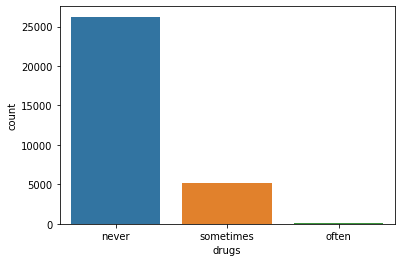

In [667]:
drinks_socially = data[data["drinks"] == 'socially']
print(drinks_socially['drinks'].value_counts())
sns.countplot(x="drugs", data=drinks_socially)
plt.show()


very often     471
desperately    322
Name: drinks, dtype: int64


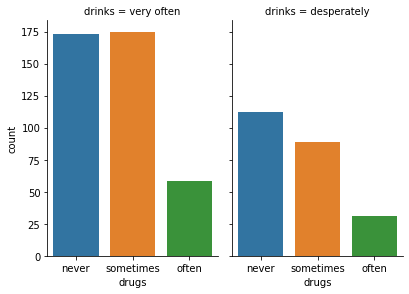

In [668]:
drinks_alot = data[(data["drinks"] != 'socially') & (data["drinks"] != 'rarely') & (data["drinks"] != 'not at all') & (data["drinks"] != 'often')]

print(drinks_alot['drinks'].value_counts())
g = sns.catplot(x="drugs", col="drinks",

                data=drinks_alot, kind="count",

                height=4, aspect=.7)
plt.show()


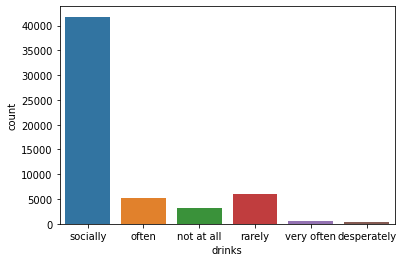

In [669]:
sns.countplot(data=data, x='drinks')
plt.show()

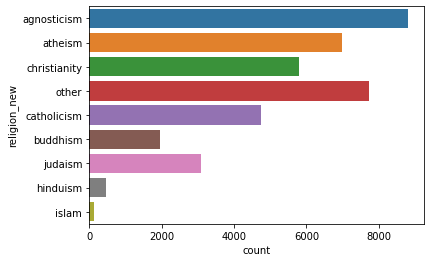

In [670]:
data['religion_new'] = data.religion.str.split().str.get(0)
sns.countplot(data=data, y="religion_new")
plt.show()

Predicting drug use with numerical features and labels.

Converting continuous categories to numerical categories.

In [671]:
cleanup_nums = {"drinks":     {"not at all": 1, "rarely": 2, "socially":3, "often":4,"very often":5,"desperately":6},
                "drugs" :     {"never" : 1, "sometimes": 2, "often": 3}}
obj_df = data.replace(cleanup_nums)
obj_df = obj_df.dropna(axis=0)

- select features and value to predict
- train, test, split the data
- create and train model on training data
- score model on test data

In [672]:
features = obj_df[['drinks','age','income','height']]
winnings = obj_df[['drugs']]

features_train, features_test, winnings_train, winnings_test = train_test_split(features, winnings, train_size = 0.8)

model = LinearRegression()
model.fit(features_train,winnings_train)

print('Test Score:', model.score(features_test,winnings_test))

Test Score: 0.09883034061770757


In [673]:
cols = ['body_type', 'diet', 'orientation', 'pets', 'religion_new','ethnicity','smokes','offspring','sex','drugs']
df = data[cols].dropna()
df.shape

(8264, 10)

In [674]:
for col in cols[:-1]:
    df = pd.get_dummies(df, columns=[col], prefix = [col])


In [675]:
df.head(100)

,drugs,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,orientation_bisexual,orientation_gay,orientation_straight,pets_dislikes cats,pets_dislikes dogs,pets_dislikes dogs and dislikes cats,pets_dislikes dogs and has cats,pets_dislikes dogs and likes cats,pets_has cats,pets_has dogs,pets_has dogs and dislikes cats,pets_has dogs and has cats,pets_has dogs and likes cats,pets_likes cats,pets_likes dogs,pets_likes dogs and dislikes cats,pets_likes dogs and has cats,pets_likes dogs and likes cats,religion_new_agnosticism,religion_new_atheism,religion_new_buddhism,religion_new_catholicism,religion_new_christianity,religion_new_hinduism,religion_new_islam,religion_new_judaism,religion_new_other,ethnicity_asian,"ethnicity_asian, black","ethnicity_asian, black, hispanic / latin","ethnicity_asian, black, hispanic / latin, other","ethnicity_asian, black, indian","ethnicity_asian, black, native american","ethnicity_asian, black, native american, pacific islander","ethnicity_asian, black, native american, pacific islander, white","ethnicity_asian, black, other","ethnicity_asian, black, pacific islander, hispanic / latin","ethnicity_asian, black, pacific islander, white","ethnicity_asian, black, pacific islander, white, other","ethnicity_asian, black, white","ethnicity_asian, hispanic / latin","ethnicity_asian, hispanic / latin, other","ethnicity_asian, hispanic / latin, white","ethnicity_asian, hispanic / latin, white, other","ethnicity_asian, indian","ethnicity_asian, indian, other","ethnicity_asian, indian, pacific islander, other","ethnicity_asian, indian, white, other","ethnicity_asian, middle eastern","ethnicity_asian, middle eastern, black","ethnicity_asian, middle eastern, black, native american, indian, pacific islander, hispanic / latin, other","ethnicity_asian, middle eastern, black, native american, indian, pacific islander, hispanic / latin, white","ethnicity_asian, middle eastern, black, native american, indian, pacific islander, hispanic / latin, white, other","ethnicity_asian, middle eastern, indian","ethnicity_asian, middle eastern, indian, hispanic / latin, white, other","ethnicity_asian, middle eastern, native american, hispanic / latin, white","ethnicity_asian, middle eastern, native american, pacific islander, white, other","ethnicity_asian, middle eastern, white","ethnicity_asian, native american, hispanic / latin","ethnicity_asian, native american, hispanic / latin, white","ethnicity_asian, native american, hispanic / latin, white, other","ethnicity_asian, native american, indian, pacific islander, hispanic / latin, white","ethnicity_asian, native american, indian, pacific islander, hispanic / latin, white, other","ethnicity_asian, native american, pacific islander","ethnicity_asian, native american, pacific islander, hispanic / latin, white","ethnicity_asian, native american, white","ethnicity_asian, native american, white, other","ethnicity_asian, other","ethnicity_asian, pacific islander","ethnicity_asian, pacific islander, hispanic / latin","ethnicity_asian, pacific islander, hispanic / latin, other","ethnicity_asian, pacific islander, hispanic / latin, white","ethnicity_asian, pacific islander, other","ethnicity_asian, pacific islander, white","ethnicity_asian, pacific islander, white, other","ethnicity_asian, white","ethnicity_asian, white, other",ethnicity_black,"ethnicity_black, hispanic / latin","ethnicity_black, hispanic / latin, other","ethnicity_black, hispanic / latin, white","ethnicity_black, indian","ethnicity_black, indian

In [676]:

df.drugs.value_counts()

never        6602
sometimes    1553
often         109
Name: drugs, dtype: int64

In [677]:
col_length = len(df.columns)

#Y is the target column, X has the rest
X = df.iloc[:, 1:col_length]
Y = df.iloc[:, 0:1]

#Validation chunk size
val_size = 0.2

#Split the data
from sklearn.model_selection import train_test_split 
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=val_size, random_state = 0)

#turn in to 1d arrays
Y_train = Y_train.to_numpy().ravel()
Y_val = Y_val.to_numpy().ravel()

In [678]:
lr_model = LogisticRegression(multi_class="multinomial",dual=False,max_iter=1200000).fit(X_train, Y_train)
lr_predictions = lr_model.predict(X_train)

- **Accuracy:** is the correct values divided by total values
- **Precision:** is the True Positives divided by the sum of True Positives and False Negatives. So precision is the values of the true positives divided by the actual positive values.
- **Recall:** is the True Positives divided by the sum of True Positives and False Positives. So recall is the values of the true positives divided by the positive guesses.
- **F1-score:** is a blended score of precision and recall which balances both values.
- **Macro Avg:** is the unweighted mean value of precision and recall. 
- **Weighted Avg:** is the weighted mean value of precision and recall by the support values for each class.
- **Support:** is the number of observations in class to predict.

The final accuracy of the logistic regression model is 83% considering a random guess should result in being correct ~33% of the time (1/3).

In [679]:
print(classification_report(Y_train, lr_predictions))

              precision    recall  f1-score   support

       never       0.85      0.96      0.90      5281
       often       0.73      0.09      0.16        86
   sometimes       0.60      0.31      0.41      1244

    accuracy                           0.82      6611
   macro avg       0.72      0.45      0.49      6611
weighted avg       0.80      0.82      0.80      6611



#### K Nearest Neighbor

The next models is the `KNeighborsClassifier` which will take 20 of it's neighbors to predict the drug use. This model had a 84% accuracy which is a good sign.

In [680]:
knn_model = KNeighborsClassifier(n_neighbors = 5).fit(X_train, Y_train)
knn_predictions = knn_model.predict(X_train)
print(classification_report(Y_train, knn_predictions))

              precision    recall  f1-score   support

       never       0.85      0.98      0.91      5281
       often       0.62      0.06      0.11        86
   sometimes       0.73      0.31      0.43      1244

    accuracy                           0.84      6611
   macro avg       0.73      0.45      0.48      6611
weighted avg       0.82      0.84      0.81      6611



#### Decision Trees

The results are very promising because it has a 99% accuracy with this model.

In [681]:
cart_model = DecisionTreeClassifier().fit(X_train, Y_train) 
cart_predictions = cart_model.predict(X_train) 
print(classification_report(Y_train, cart_predictions))

              precision    recall  f1-score   support

       never       0.97      1.00      0.99      5281
       often       0.99      0.94      0.96        86
   sometimes       0.99      0.89      0.94      1244

    accuracy                           0.98      6611
   macro avg       0.98      0.94      0.96      6611
weighted avg       0.98      0.98      0.98      6611



### Confusion Matrix

In the confusion matrix **never** was predicted most often correct and **sometimes** second. 

**Sometimes** was 85 times mistaken with never. **Often** was almost perfectly predictet. Only once **often** was falsly predicted as **never**. 

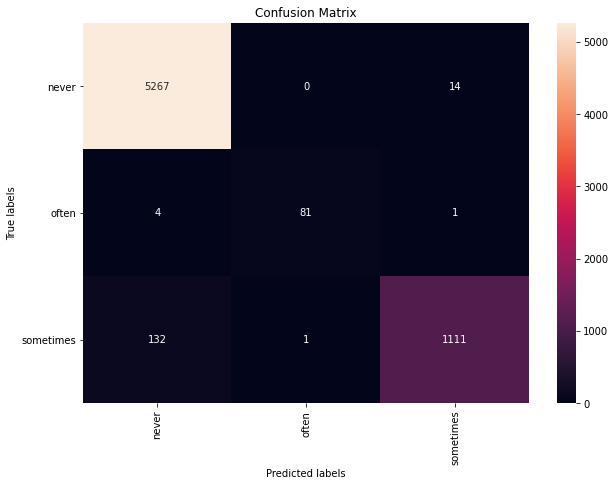

In [682]:
cart_cm = confusion_matrix(Y_train, cart_predictions)
cart_labels = cart_model.classes_


plt.figure(figsize=(10,7))

ax= plt.subplot()
sns.heatmap(cart_cm, annot=True, ax = ax,fmt="d");

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.yaxis.set_tick_params(rotation=360)
ax.xaxis.set_tick_params(rotation=90)

ax.xaxis.set_ticklabels(cart_labels); 
ax.yaxis.set_ticklabels(cart_labels);

 five fold cross validation is created with the same data. The results are worse than the KNN and about the same as the Logistic Regression algorithms.

In [683]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_val_score(cart_model, X_train, Y_train, cv=kfold, scoring='accuracy')

print(results)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.7271353  0.72995461 0.7269289  0.75945537 0.74432678]
Baseline: 73.76% (1.27%)
